## Call the import statements

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_rows=10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
tf.keras.backend.set_floatx('float32') # set defaults float type

## Load, scale, and shuffle the examples

In [4]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [5]:
train_df.iloc[3664]

longitude              -117.9
latitude                 33.8
housing_median_age       34.0
total_rooms             988.0
total_bedrooms          173.0
population              759.0
households              184.0
median_income             5.6
median_house_value   205100.0
Name: 3664, dtype: float64

In [6]:
scale_factor = 1000
train_df['median_house_value'] = train_df['median_house_value'] / scale_factor
test_df['median_house_value'] /= scale_factor

In [7]:
train_df = train_df.sample(frac=1) # or
train_df = train_df.reindex(np.random.permutation(train_df.index))

## Represent latitude and longitude as floating-point values

In [8]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

In [9]:
# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column('latitude')
feature_columns.append(latitude)

In [10]:
# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column('longitude')
feature_columns.append(longitude)

In [11]:
len(feature_columns)

2

In [12]:
# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

## what happened inside feature_layer?

In [13]:
tdf1 = train_df.to_dict() #ordereddict

In [14]:
tdf1['latitude'] = tdf1['latitude'].values() # convert to list by removing index

In [15]:
tdf1['longitude'] = tdf1['longitude'].values()

In [16]:
fp_feature_layer(tdf1)

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[  34.07, -118.11],
       [  39.73, -121.82],
       [  38.03, -121.97],
       ...,
       [  33.69, -116.39],
       [  34.12, -118.15],
       [  37.79, -122.24]], dtype=float32)>

## Define functions that create and train a model, and a plotting function

In [17]:
def create_model(my_learning_rate, feature_layer):
    model = tf.keras.models.Sequential()
    # Add the layer containing the feature columns to the model.
    model.add(feature_layer)
    # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),
                 loss='mean_squared_error',
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [18]:
def train_model(model, dataset, epochs, batch_size, label_name):
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                       epochs=epochs, shuffle=True)
    
    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
    
    # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist['root_mean_squared_error']
    
    return epochs, rmse

In [19]:
def plot_the_loss_curve(epochs, rmse):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    
    plt.plot(epochs, rmse, label='Loss')
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()*1.05])
    plt.show()
    
print('Defined the create_model, train_model, and plot_the_loss-curve functions')

Defined the create_model, train_model, and plot_the_loss-curve functions


## Train the model with floating-point representations

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 13963.1445 - root_mean_squared_error: 118.1657
Epoch 2/30
170/170 [==============================] - 0s 2ms/step - loss: 13471.8672 - root_mean_squared_error: 116.0684
Epoch 3/30
170/170 [==============================] - 0s 2ms/step - loss: 13442.6748 - root_mean_squared_error: 115.9426A: 0s - loss: 13719.5391 - root_mean_squared_error: 11
Epoch 4/30
170/170 [==============================] - 0s 2ms/step - loss: 13381.9473 - root_mean_squared_error: 115.6804
Epoch 5/30
170/170 [==============================] - 0s 2ms/step - loss: 13342.4707 - root_mean_squared_error: 115.5096
Epoch 6/30
170/170 [==============================] - 0s 2ms/step - loss: 13299.4121 - root_mean_squared_error: 115.3231
Epoch 7/30
170/170 [==============================] - 0s 2ms/step - loss: 13268.6084 - root_mean_squared_error

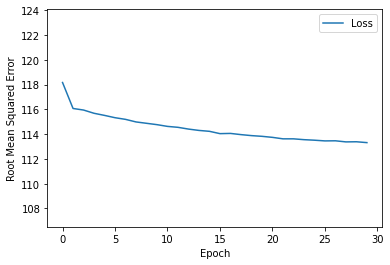


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 2ms/step - loss: 12178.5215 - root_mean_squared_error: 110.3563


[12178.521484375, 110.35633850097656]

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print('\n: Evaluate the new model against the test set:')
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## tf.feature_column.numeric_column

In [21]:
data = {'a': [15, 9, 17, 19, 21, 18, 25, 30],
   'b': [5.0, 6.4, 10.5, 13.6, 15.7, 19.9, 20.3 , 0.0]}

In [22]:
a = tf.feature_column.numeric_column('a')
b = tf.feature_column.numeric_column('b')

In [23]:
a_buckets = tf.feature_column.bucketized_column(a,
   boundaries=[10, 15, 20, 25, 30])

In [24]:
feature_layer = tf.keras.layers.DenseFeatures([a, b])
print(feature_layer(data))

tf.Tensor(
[[15.   5. ]
 [ 9.   6.4]
 [17.  10.5]
 [19.  13.6]
 [21.  15.7]
 [18.  19.9]
 [25.  20.3]
 [30.   0. ]], shape=(8, 2), dtype=float32)


In [25]:
feature_layer = tf.keras.layers.DenseFeatures([a_buckets, b])
print(feature_layer(data))

tf.Tensor(
[[ 0.   0.   1.   0.   0.   0.   5. ]
 [ 1.   0.   0.   0.   0.   0.   6.4]
 [ 0.   0.   1.   0.   0.   0.  10.5]
 [ 0.   0.   1.   0.   0.   0.  13.6]
 [ 0.   0.   0.   1.   0.   0.  15.7]
 [ 0.   0.   1.   0.   0.   0.  19.9]
 [ 0.   0.   0.   0.   1.   0.  20.3]
 [ 0.   0.   0.   0.   0.   1.   0. ]], shape=(8, 7), dtype=float32)


In [26]:
feature_layer = tf.keras.layers.DenseFeatures([a_buckets])
print(feature_layer(data))

tf.Tensor(
[[0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]], shape=(8, 6), dtype=float32)


## Task 1: Why aren't floating-point values a good way to represent latitude and longitude?

@title Double-click to view an answer to Task 1.

No. Representing latitude and longitude as floating-point values does not have much predictive power. For example, neighborhoods at latitude 35 are not 36/35 more valuable (or 35/36 less valuable) than houses at latitude 36.

Representing `latitude` and `longitude` as floating-point values provides almost no 
predictive power. We're only using the raw values to establish a baseline for future experiments 
with better representations.

## Represent latitude and longitude in buckets

In [27]:
resolution_in_degrees = 1.0

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude
# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])), 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])), 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.

buckets_feature_layer = layers.DenseFeatures(feature_columns)

## Train the model with bucket representations

Epoch 1/35
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
170/170 [==============================] - 1s 2ms/step - loss: 52165.1055 - root_mean_squared_error: 228.3968
Epoch 2/35
170/170 [==============================] - 0s 2ms/step - loss: 44763.5117 - root_mean_squared_error: 211.5739
Epoch 3/35
170/170 [==============================] - 0s 2ms/step - loss: 38167.8438 - root_mean_squared_error: 195.3659
Epoch 4/35
170/170 [==============================] - 1s 3ms/step - loss: 32321.6758 - root_mean_squared_error: 179.7823
Epoch 5/35
170/170 [==============================] - 0s 3ms/step - loss: 27311.0879 - root_mean_squared_error: 165.2607
Epoch 6/35
170/170 [==============================] - 0s 3ms/step - loss: 23044.8652 - root_mean_squared_error: 151.8054
Epoch 7/35
170/170 [==============================] - 0s 2ms/step - loss: 19522.1035 - root_mean_squared_error: 139.7215
Epoch 8/35
170/170 [=======================

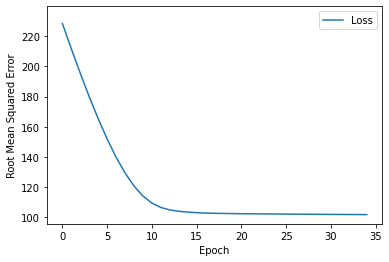


: Evaluate the new model against the test set:
Consider rewriting this model with the Functional API.
30/30 [==============================] - 0s 2ms/step - loss: 10199.1914 - root_mean_squared_error: 100.9910


[10199.19140625, 100.99104309082031]

In [28]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35
batch_size = 100
label_name = 'median_house_value'

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

#Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print('\n: Evaluate the new model against the test set:')
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## Task 2: Did buckets outperform floating-point representations?

### @title Double-click for an answer to Task 2.

Bucket representation outperformed floating-point representations.  
However, you can still do far better.

## Task 3: What is a better way to represent location?

Buckets are a big improvement over floating-point values. Can you identify an even better way to identify location with latitude and longitude?